# softmax回归从零开始实现

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import platform
import matplotlib.pyplot as plt

## 1 获取和读取数据

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [4]:
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))
feature, label = mnist_train[0]
print(feature.shape, label)

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
torch.Size([1, 28, 28]) 9


In [5]:
batch_size = 256
system = platform.system()
num_workers = 4 if system == 'Linux' else 0
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2 初始化模型参数

In [6]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.1, (num_inputs, num_outputs), dtype=torch.float32)  # 784*10
b = torch.normal(0, 0.01, (1, num_outputs), dtype=torch.float32)  # 偏差参数1*10

In [7]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([[ 0.0160, -0.0011,  0.0042, -0.0075, -0.0144,  0.0024,  0.0019, -0.0046,
          0.0062, -0.0054]], requires_grad=True)

## 3 实现softmax运算

In [8]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim = 1,keepdim = True)
    return X_exp / partition

## 4 定义模型

In [9]:
def softmax_net(X):
    return softmax(torch.mm(X.view((-1,num_inputs)),W) + b)

## 5 定义损失函数

$$\ell(\theta)=\frac{1}{n} \sum_{i=1}^{n} H\left(\hat{y}^{(i)}, y^{(i)}\right)=-\frac{1}{n} \sum_{i=1}^{n} \log \hat{y}_{y^{(i)}}^{(i)}$$

In [10]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1,y.view(-1,1)))

## 6 定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 7 计算分类准确率

In [12]:
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1)==y).sum().item()

In [13]:
def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for x,y in data_iter:
        acc_sum += (net(x).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

## 8 训练模型

In [14]:
num_epochs=15
lr=0.1
net=softmax_net
loss=cross_entropy
optimizer=sgd
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, test_acc, n = 0.0, 0.0, 0.0, 0
    for x,y in train_iter:
        y_hat=net(x)
        l = loss(y_hat,y).sum()
        
        l.backward()  # 求梯度
        sgd([W, b], lr, batch_size)  # 参数更新
        W.grad.data.zero_()
        b.grad.data.zero_()  # 梯度清零
        
        train_l_sum+=l.item()
        train_acc_sum+=accuracy(y_hat,y)
        n+=y.shape[0]
    test_acc+=evaluate_accuracy(test_iter,net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, loss 0.8205, train acc 0.722, test acc 0.781
epoch 2, loss 0.5813, train acc 0.805, test acc 0.798
epoch 3, loss 0.5351, train acc 0.820, test acc 0.814
epoch 4, loss 0.5097, train acc 0.828, test acc 0.818
epoch 5, loss 0.4927, train acc 0.834, test acc 0.824
epoch 6, loss 0.4793, train acc 0.838, test acc 0.824
epoch 7, loss 0.4703, train acc 0.841, test acc 0.826
epoch 8, loss 0.4632, train acc 0.842, test acc 0.828
epoch 9, loss 0.4571, train acc 0.844, test acc 0.830
epoch 10, loss 0.4523, train acc 0.846, test acc 0.828
epoch 11, loss 0.4473, train acc 0.848, test acc 0.831
epoch 12, loss 0.4439, train acc 0.847, test acc 0.833
epoch 13, loss 0.4399, train acc 0.849, test acc 0.834
epoch 14, loss 0.4363, train acc 0.851, test acc 0.836
epoch 15, loss 0.4355, train acc 0.851, test acc 0.836


## 9 预测

In [18]:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [19]:
def show_fashion_mnist(images,labels):
    _,figs = plt.subplots(1,len(images),figsize=(20,20))
    for f,img,lbl in zip(figs,images,labels):
        f.imshow(img.view((28,28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

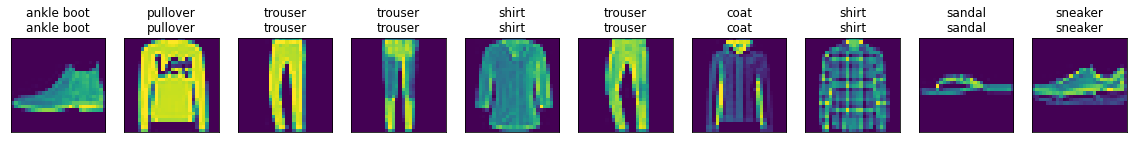

In [20]:
x,y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x).argmax(dim=1).numpy())
titles=[true+'\n'+pred for true, pred in zip(true_labels,pred_labels)]
show_fashion_mnist(x[0:10],titles[0:10])